In [1]:
import torch
import torch.nn as nn

DEVICE = ('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
PAD_ID = 0
S_ID = 1
EOS_ID = 2
UNK_ID = 3

In [2]:
DEVICE

'cuda'

In [3]:
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

In [4]:
!pip install datasets

In [5]:
import datasets

train_data = datasets.load_dataset('wmt16','de-en',split='train[:50000]')
val_data = datasets.load_dataset('wmt16',"de-en", split="validation")
test_data = datasets.load_dataset('wmt16','de-en', split="test")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/raid/home/akshat21515/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_data.shape

(50000, 1)

In [7]:
val_data.shape

(2169, 1)

In [8]:
test_data.shape

(2999, 1)

In [9]:
from torch import Tensor
from torch.nn import Module

class PositionalEncodings(Module):
    def __init__(self, d_model:int, max_len:int=512):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        pe = torch.zeros((max_len, d_model))
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x:Tensor):
        return (self.pe[:x.size(1), :]).unsqueeze(0)

In [10]:
from torch.nn import Embedding

class TokenEmbedding(Module):
    def __init__(self, vocab_size:int, d_model:int):
        super().__init__()
        self.embed = Embedding(vocab_size, d_model)
        self.d_model = d_model
        self.vocab_size = vocab_size

    def forward(self, x:Tensor):
        return self.embed(x.long())

In [11]:
from torch.nn import Transformer,Linear,Sequential,Dropout
from typing import Any,List

class TransformerTranslation(Module):
    def __init__(self, src_vocab_size:int,
                 tgt_vocab_size:int,
                 emb_sizes:List[int],
                 d_model:int,
                 nhead:int,
                 num_encoder_layers:int,
                 num_decoder_layers:int,
                 dim_feedforward:int,
                 dropout:float=0.1,
                 activation:Any='relu'):
        super().__init__()

        self.transformer = Transformer(d_model=d_model,
                                        nhead=nhead,
                                        num_encoder_layers=num_encoder_layers,
                                        num_decoder_layers=num_decoder_layers,
                                        dim_feedforward=dim_feedforward,
                                        dropout=dropout,
                                        activation=activation,
                                        batch_first=True)
        self.generator = Sequential(
            nn.ReLU(inplace=True),
            Linear(d_model,tgt_vocab_size),
            nn.LogSoftmax(dim=-1))
        src_emb_size,tgt_emb_size = emb_sizes
        self.src_emb = TokenEmbedding(src_vocab_size,src_emb_size)
        self.tgt_emb = TokenEmbedding(tgt_vocab_size,tgt_emb_size)
        self.src_pos = PositionalEncodings(src_emb_size)
        self.tgt_pos = PositionalEncodings(tgt_emb_size)

    def forward(self,
                src:Tensor,
                tgt:Tensor,
                src_mask:Tensor=None,
                tgt_mask:Tensor=None,
                src_padding_mask:Tensor=None,
                tgt_padding_mask:Tensor=None,
                memory_key_padding_mask:Tensor=None):
        src_inp = self.src_emb(src) + self.src_pos(src)
        tgt_inp = self.tgt_emb(tgt) + self.tgt_pos(tgt)
        output = self.transformer(src=src_inp,
                                  tgt=tgt_inp,
                                  src_mask=src_mask,
                                  tgt_mask=tgt_mask,
                                  memory_mask=None,
                                  src_key_padding_mask=src_padding_mask,
                                  tgt_key_padding_mask=tgt_padding_mask,
                                  memory_key_padding_mask=memory_key_padding_mask
                                )
        return self.generator(output)

    def encode(self, src:Tensor, src_mask:Tensor):
        return self.transformer.encoder(self.src_emb(src) + self.src_pos(src), src_mask)

    def decode(self, tgt:Tensor, memory:Tensor, tgt_mask:Tensor):
        return self.transformer.decoder(self.tgt_emb(tgt) + self.tgt_pos(tgt), memory, tgt_mask)

In [12]:
def generate_subsequent_mask(dim:int):
    mask = (torch.triu(torch.ones((dim,dim), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [13]:
def generate_mask(src:Tensor, tgt:Tensor):
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)
    tgt_mask = generate_subsequent_mask(tgt_seq_len)
    mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE)
    src_mask = mask.float().masked_fill(mask == 1, float('-inf')).masked_fill(mask == 0, float(0.0))
    src_padding_mask = (src == PAD_ID)
    tgt_padding_mask = (tgt == PAD_ID)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [14]:
def compute_vocab(dataset,language):
    all_tokens = (' '.join(sample[language] for sample in dataset['translation'])).split()
    vocab = set(all_tokens)
    return all_tokens,vocab,len(vocab)

In [15]:
from tokenizers import Tokenizer,models
from tokenizers.trainers import BpeTrainer

src_tokens,src_vocab,src_vocab_size = compute_vocab(train_data,'de')
tgt_tokens,tgt_vocab,tgt_vocab_size = compute_vocab(train_data,'en')

tokenizer_de = Tokenizer(models.BPE())
tokenizer_en = Tokenizer(models.BPE())

special_tokens = ['<pad>', '<s>', '</s>', '<unk>']
trainer = BpeTrainer(special_tokens=special_tokens)

tokenizer_de.train_from_iterator(src_tokens,trainer=trainer)
tokenizer_en.train_from_iterator(tgt_tokens,trainer=trainer)

In [16]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

d_model = 128
emb_sizes = [128,128]
nhead = 16
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 256
batch_size = 32
dropout = 0.2
activation = 'relu'
learning_rate = 0.0001
betas = (0.33, 0.81)
eps = 1e-9

translator = TransformerTranslation(src_vocab_size,
                                    tgt_vocab_size,
                                    emb_sizes,
                                    d_model,
                                    nhead,
                                    num_encoder_layers,
                                    num_decoder_layers,
                                    dim_feedforward,
                                    dropout,
                                    activation)
for p in translator.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

loss_fn = CrossEntropyLoss()
optimizer = optim.Adam(translator.parameters(),lr=learning_rate,betas=betas)

In [17]:
from torch.nn.utils.rnn import pad_sequence

def tensor_transform(tokenizer,text):
    token_ids = tokenizer.encode(text).ids
    return torch.cat([torch.tensor([S_ID]),torch.tensor(token_ids)])

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for sample in batch:
        src_batch.append(tensor_transform(tokenizer_de,sample['translation']['de']))
        tgt_batch.append(tensor_transform(tokenizer_en,sample['translation']['en']))
    src_batch = pad_sequence(src_batch, padding_value=PAD_ID, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_ID, batch_first=True)
    return src_batch, tgt_batch

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

def model_epoch(model, data_loader, loss_fn, optimizer, is_train:bool):
    model.to(DEVICE)
    model.train(is_train)
    total_loss = 0

    for src, tgt in data_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        tgt_input = tgt[:, :-1]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = generate_mask(src, tgt_input)
        with torch.set_grad_enabled(is_train):
            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            tgt_out = tgt[:, 1:]
            loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            total_loss += loss.item()
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    return total_loss / len(data_loader)

In [35]:
num_epochs = 15
train_losses, val_losses = [], []
min_val_loss = 1e10
bad_epochs = 0

for epoch in range(num_epochs):
    train_loss = model_epoch(translator, train_loader, loss_fn, optimizer, is_train=True)
    val_loss = model_epoch(translator, val_loader, loss_fn, optimizer, is_train=False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (val_loss<min_val_loss):
        min_val_loss = val_loss
        bad_epochs = 0
    else:
        bad_epochs+=1

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss}')
    print(f'Epoch {epoch+1}/{num_epochs} | Val Loss: {val_loss}')
    print("----------------------------------------------")

    if(bad_epochs==num_epochs//7):
        print("Stopping early...")
        break

/raid/home/akshat21515/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/raid/home/akshat21515/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1/15 | Train Loss: 4.938961004188864
Epoch 1/15 | Val Loss: 3.6660573342267204
----------------------------------------------
Epoch 2/15 | Train Loss: 2.759452155287725
Epoch 2/15 | Val Loss: 3.5527605800067676
----------------------------------------------
Epoch 3/15 | Train Loss: 2.6707135252821392
Epoch 3/15 | Val Loss: 3.5182547954952015
----------------------------------------------
Epoch 4/15 | Train Loss: 2.6285146834449136
Epoch 4/15 | Val Loss: 3.5148937228847954
----------------------------------------------
Epoch 5/15 | Train Loss: 2.6008892336565945
Epoch 5/15 | Val Loss: 3.478986179127413
----------------------------------------------
Epoch 6/15 | Train Loss: 2.5710763398913032
Epoch 6/15 | Val Loss: 3.483608422910466
----------------------------------------------
Epoch 7/15 | Train Loss: 2.531700572255172
Epoch 7/15 | Val Loss: 3.4585789144039154
----------------------------------------------
Epoch 8/15 | Train Loss: 2.5050010583527333
Epoch 8/15 | Val Loss: 3.44937

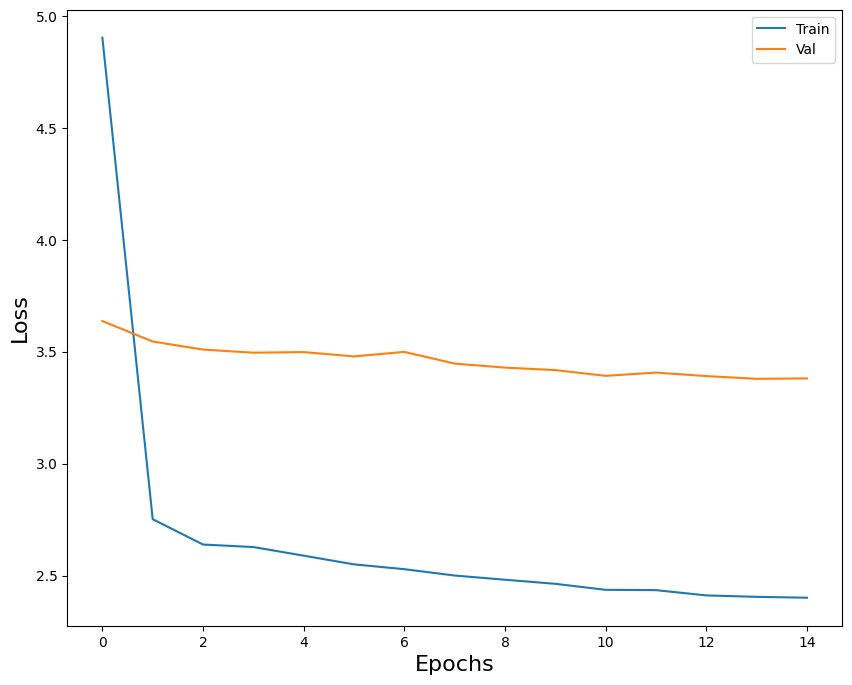

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(train_losses, label="Train")
if(len(val_losses)>0):
    plt.plot(val_losses, label="Val")

plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

In [19]:
def greedy_decode(model,src,src_mask,max_len=512,start_symbol=S_ID):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    memory = model.encode(src, src_mask)
    memory = memory.to(DEVICE)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        tgt_mask = (generate_subsequent_mask(ys.size(1))).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word[-1].item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_ID:
            break
    return ys

In [20]:
def translate_2A(model:Module,tokenizer_de,tokenizer_en,src_sentence:str):
    model.eval()
    model.to(DEVICE)
    src = (tensor_transform(tokenizer_de,src_sentence)).view(1,-1)
    num_tokens = src.size(1)
    src_mask = (torch.zeros(num_tokens,num_tokens))
    tgt = greedy_decode(model,src,src_mask,num_tokens+5,S_ID).flatten()
    return tokenizer_en.decode(tgt.cpu().numpy(),skip_special_tokens=True)

In [21]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
import evaluate

2024-04-20 13:51:20.233873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 13:51:21.049515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
# candidates = []
# references = []

# for sample in test_data['translation']:
#     src,tgt = sample['de'],sample['en']
#     translation = translate_2A(translator,tokenizer_de,tokenizer_en,src)
#     candidates.append(translation)
#     references.append(tgt)

In [ ]:
bleu_metric = evaluate.load('bleu')

bleu = bleu_metric.compute(predictions=candidates,references=references)
print(f"BLEU-1: {bleu['precisions'][0]}")
print(f"BLEU-2: {bleu['precisions'][1]}")
print(f"BLEU-3: {bleu['precisions'][2]}")
print(f"BLEU-4: {bleu['precisions'][3]}")

BLEU-1: 0.03766300527701717
BLEU-2: 0.0012564991334488734
BLEU-3: 6.717345305135411e-05
BLEU-4: 0.0


In [ ]:
meteor_metric = evaluate.load('meteor')

meteor = meteor_metric.compute(predictions=candidates,references=references)
print(f"Meteor Score: {meteor['meteor']}")

[nltk_data] Downloading package wordnet to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /raid/home/akshat21515/nltk_data...


Meteor Score: 0.03380934961341056


In [ ]:
!pip install bert_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
bertscore_metric = evaluate.load('bertscore')

bertscore = bertscore_metric.compute(predictions=candidates, references=references, model_type="distilbert-base-uncased")
print(f"BERTScore: {sum(bertscore['precision'])/len(bertscore['precision'])}")

ImportError: To be able to use evaluate-metric/bertscore, you need to install the following dependencies['bert_score'] using 'pip install bert_score' for instance'

In [24]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer


bleu_metric = evaluate.load('bleu')
meteor_metric = evaluate.load('meteor')
# bertscore_metric = evaluate.load('bertscore')


checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model_2b = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

def translate_2B(model_2b, tokenizer, text):
    input_text = "translate German to English: " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    outputs = model_2b.generate(input_ids)
    german_translation = tokenizer.decode(outputs[0])

    return german_translation

# translations = []
# references = []
# for item in val_data:
#     english_text = item['translation']['en']
#     german_translation = translate_2B(model_2b, tokenizer, english_text)
#     translations.append(german_translation)
#     references.append(item['translation']['de'])
#     if(len(translations) % 500 == 0):
#       print(len(translations))

# bleu = bleu_metric.compute(predictions=translations, references=references)
# meteor = meteor_metric.compute(predictions=translations, references=references)
# # bertscore = bertscore_metric.compute(predictions=translations, references=references, lang='en')

# print(f"Validation BLEU-1: {bleu['precisions'][0]}")
# print(f"Validation BLEU-2: {bleu['precisions'][1]}")
# print(f"Validation BLEU-3: {bleu['precisions'][2]}")
# print(f"Validation BLEU-4: {bleu['precisions'][3]}")
# print(f"Validation METEOR: {meteor['meteor']}")
# print(f"Validation BERTScore: {bertscore['f1']}")

# translations = []
# references = []
# for item in test_data:
#     english_text = item['translation']['en']
#     german_translation = translate_2B(model_2b, tokenizer, english_text)
#     translations.append(german_translation)
#     references.append(item['translation']['de'])
#     if(len(translations) % 50 == 0):
#       print(len(translations))
      
# bleu = bleu_metric.compute(predictions=translations, references=references)
# meteor = meteor_metric.compute(predictions=translations, references=references)
# # bertscore = bertscore_metric.compute(predictions=translations, references=references, lang='en')

# print(f"Test BLEU-1: {bleu['precisions'][0]}")
# print(f"Test BLEU-2: {bleu['precisions'][1]}")
# print(f"Test BLEU-3: {bleu['precisions'][2]}")
# print(f"Test BLEU-4: {bleu['precisions'][3]}")
# print(f"Test METEOR: {meteor['meteor']}")
# print(f"Test BERTScore: {bertscore['f1']}")

[nltk_data] Downloading package wordnet to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
print(f"Test BLEU-1: {bleu['precisions'][0]}")
print(f"Test BLEU-2: {bleu['precisions'][1]}")
print(f"Test BLEU-3: {bleu['precisions'][2]}")
print(f"Test BLEU-4: {bleu['precisions'][3]}")
print(f"Test METEOR: {meteor['meteor']}")
print(f"Test BERTScore: {bertscore['f1']}")

Test BLEU-1: 0.45546615170046134
Test BLEU-2: 0.268678622207953
Test BLEU-3: 0.17319673947841505
Test BLEU-4: 0.11587960008508828
Test METEOR: 0.34849179722066537
Test BERTScore: [0.863649845123291, 0.921355664730072, 0.9038230776786804, 0.8924747705459595, 0.9258562326431274, 0.8644993305206299, 0.8429644703865051, 0.8770416975021362, 0.8773070573806763, 0.8750308156013489, 0.8455091118812561, 0.8470861911773682, 0.8262258172035217, 0.8300788402557373, 0.7915123701095581, 0.871814489364624, 0.8867651224136353, 0.8347976207733154, 0.8287848234176636, 0.8852449059486389, 0.9002132415771484, 0.848119854927063, 0.8794133067131042, 0.8976000547409058, 0.8844802379608154, 0.8714832663536072, 0.8623412847518921, 0.9692016243934631, 0.8655409216880798, 0.8796126246452332, 0.9730011224746704, 0.8910902738571167, 0.7956358194351196, 0.9542884230613708, 0.9006202816963196, 0.9619002938270569, 0.8976296186447144, 0.8671607971191406, 0.919253945350647, 0.9048522710800171, 0.9022316932678223, 0.870

In [25]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [26]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import Dataset

In [27]:
bleu_metric = evaluate.load('bleu')
meteor_metric = evaluate.load('meteor')
bertscore_metric = evaluate.load('bertscore')

# Load pre-trained T5 model and tokenizer
checkpoint = "t5-small"
tokenizer_2c = AutoTokenizer.from_pretrained(checkpoint)
model_2c = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

[nltk_data] Downloading package wordnet to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /raid/home/akshat21515/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [28]:
def tokenize_function(example):
    example['de'] = tokenizer_2c(example['de'], padding=True, truncation=True, return_tensors="pt")
    example['en'] = tokenizer_2c(example['en'], padding=True, truncation=True, return_tensors="pt")
    return example

In [29]:
model_input = Dataset.from_list(train_data['translation']).map(tokenize_function)
model_val = Dataset.from_list(val_data['translation']).map(tokenize_function)
model_test = Dataset.from_list(test_data['translation']).map(tokenize_function)

Map: 100%|██████████| 2999/2999 [00:01<00:00, 1737.26 examples/s]


In [30]:
# Define translation function
def translate_2C(model,tokenizer,text:str):
    input_text = "translate German to English: " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    outputs = model.generate(input_ids)
    en_translation = tokenizer.decode(outputs[0])

    return en_translation

In [31]:
# Define evaluation function
def evaluate_2c(model,tokenizer,data):
    translations = []
    references = []
    for item in data:
        de_text = item['translation']['de']
        en_translation = translate_2C(model,tokenizer,de_text)
        translations.append(en_translation)
        references.append(item['translation']['en'])

    bleu = bleu_metric.compute(predictions=translations, references=references)
    meteor = meteor_metric.compute(predictions=translations, references=references)
    # bertscore = bertscore_metric.compute(predictions=translations, references=references, model_type="distilbert-base-uncased")

    return bleu, meteor

In [39]:
# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    overwrite_output_dir=True,
    save_total_limit=3,
#     fp16=True
)

# Define trainer
trainer = Seq2SeqTrainer(
    model=model_2c,
    tokenizer=tokenizer_2c,
    args=training_args,
    train_dataset=model_input,
    eval_dataset=model_val,
    data_collator=DataCollatorForSeq2Seq(tokenizer_2c, model=model_2c, max_length=128),
    compute_metrics=evaluate
)

# Train the model
trainer.train()
trainer.save_model('fine_tuned_t5-small')

train_loss = trainer.state.log_history["loss"]
val_loss = trainer.state.log_history["eval_loss"]

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
# Evaluate on validation data after training
val_bleu, val_meteor = evaluate_2c(model_2c,tokenizer_2c,val_data)
print("Validation Metrics:")
print(f"BLEU-1: {val_bleu['precisions'][0]}")
print(f"BLEU-2: {val_bleu['precisions'][1]}")
print(f"BLEU-3: {val_bleu['precisions'][2]}")
print(f"BLEU-4: {val_bleu['precisions'][3]}")
print(f"Meteor Score: {val_meteor['score']}")
# print(f"Validation BERTScore: {val_bertscore['score']}")

# Evaluate on test data
test_bleu, test_meteor = evaluate_2c(model_2c,tokenizer_2c,test_data)
print("Test Metrics:")
print(f"BLEU-1: {test_bleu['precisions'][0]}")
print(f"BLEU-2: {test_bleu['precisions'][1]}")
print(f"BLEU-3: {test_bleu['precisions'][2]}")
print(f"BLEU-4: {test_bleu['precisions'][3]}")
print(f"Test METEOR: {test_meteor['meteor']}")
# print(f"Test BERTScore: {sum(test_bertscore['precision'])/len(test_bertscore['precision'])}")

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


KeyboardInterrupt: 

In [32]:
def translate_sentence(sentence:str):
    print("Original Sentence: ", sentence)
    print(f"2A: {translate_2A(translator, tokenizer_de, tokenizer_en, sentence)}")
    print(f"2B: {translate_2B(model_2b, tokenizer, sentence)}")
    print(f"2C: {translate_2C(model_2c, tokenizer, sentence)}")

In [33]:
import pandas as pd

def translate_csv(csv_file:str):
    de_sents = []
    en_sents = []
    df = pd.read_csv(csv_file)
    for sentence in df['de']:
        en_translation = translate_sentence(sentence)
        de_sents.append(sentence)
        en_sents.append(en_translation)

    translated_df = pd.DataFrame({'de':de_sents, 'en':en_sents})
    translated_df.to_csv('translated.csv', index=False)

In [36]:
translate_sentence("Mal sehen, wie gut Sie diese Aufgabe gemeistert haben.")

Original Sentence:  Mal sehen, wie gut Sie diese Aufgabe gemeistert haben.
2A: I would like to be the European European European European European European European European European European
2B: <pad> Leider hat man es nicht geschafft, die ganze Aufgabe zu meister
2C: <pad> Leider hat man es nicht geschafft, die ganze Aufgabe zu meister
